## Assignment 3 - Competitive Assignment
An explanation this assignment could be found in the .pdf explanation document

### Preceding Step - import modules (packages)
This step is necessary in order to use external modules (packages). <br/>

In [1]:
# imports for reading and writing (input & output) files:
import pandas as pd
import os

In [2]:
### add whatever imports you need
# YOUR CODE HERE
!pip install wordcloud

from keras import optimizers
from keras import backend as K
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Bidirectional,Embedding
from keras.preprocessing import text, sequence
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import seaborn as sns
import numpy as np

### Reading input files
Reading input files for train annotated corpus (raw text data) corpus and for the test corpus

In [3]:
train_filename = 'annotated_corpus_for_train.xlsx'
test_filename  = 'corpus_for_test.xlsx'
df_train = pd.read_excel(train_filename, 'corpus', index_col=None, na_values=['NA'])
df_test  = pd.read_excel(test_filename,  'corpus', index_col=None, na_values=['NA'])

In [4]:
len(df_train)

364

In [5]:
df_train.head(8)

,story,gender
0,"בוקר אחד קמתי סהרורי יצאתי מהמיטה קצת מטושטש ,...",m
1,לחבר שלי היה יום הולדת וחיפשנו מה אפשר לעשות ל...,m
2,"השנה האחרונה הייתה שנת קורונה, שנה לא פשוטה בק...",m
3,"לפני כחצי שנה עברתי לגור בצפון עם בת זוגתי, עב...",m
4,"יום חמישי רגיל, תמיד מתחיל לעבור טיפה מאוחר יו...",m
5,בשנה האחרונה חוויתי את מגפת הקורונה שהכריח את ...,m
6,בסמסטר קודם אני וכמה חברים ללימודים קבענו להיפ...,m
7,בשנה האחרונה למרות שלא היו יותר מידיי דברים לע...,f


In [6]:
df_test.head(5)

,test_example_id,story
0,0,כחלק ממסגרת ההתנדבות שלי במגלה אני הולך לפעמיי...
1,1,"לפני שנה החלטתי שאני רוצה להיות טייס, התחלתי ל..."
2,2,"בתקופת הקורונה של תחילת החיסונים נגד קורונה, א..."
3,3,כפי שכולם מכירים או שמעו מחברים עולם הדייטים ה...
4,4,"אחת החוויות שהכי זכורות לי, זו החוויה בפרו בטי..."


### Your implementation:
Write your code solution in the following code-cells

In [7]:
#splitting train data
train_data = df_train['story']
train_target = df_train['gender']

#splitting train data
test_data = df_test['story']
test_target = df_test['test_example_id']

label_encode=LabelEncoder()

df_train['gender'] = label_encode.fit_transform(df_train['gender']) # converting two class as numerical values
train_target = to_categorical(df_train['gender'])

df_test['test_example_id'] = label_encode.fit_transform(df_test['test_example_id']) # converting two class as numerical values

print('X token train shape: {}'.format(df_train.shape))
print('X token test shape: {}'.format(df_test.shape))

print('X token train shape: {}'.format(train_target.shape))

X token train shape: (364, 2)
X token test shape: (156, 2)
X token train shape: (364, 2)


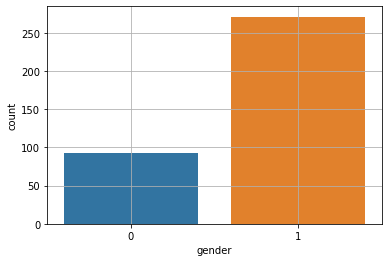

In [8]:
sns.countplot(x=df_train['gender']) # count of each classes
plt.grid()

In [9]:
print(train_data[:5])

0    בוקר אחד קמתי סהרורי יצאתי מהמיטה קצת מטושטש ,...
1    לחבר שלי היה יום הולדת וחיפשנו מה אפשר לעשות ל...
2    השנה האחרונה הייתה שנת קורונה, שנה לא פשוטה בק...
3    לפני כחצי שנה עברתי לגור בצפון עם בת זוגתי, עב...
4    יום חמישי רגיל, תמיד מתחיל לעבור טיפה מאוחר יו...
Name: story, dtype: object


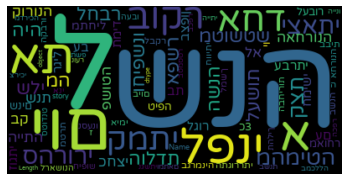

In [10]:
wordcloud = WordCloud(font_path=r'fonts/VarelaRound_Regular.ttf').generate(str(df_train['story']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
#function for word tokernizing
def tokenizer(x_train, x_test, vocabulary_size, char_level):
    tokenize = text.Tokenizer(num_words=vocabulary_size, 
                              char_level=char_level,
                              filters='')
    tokenize.fit_on_texts(x_train)  # only fit on train
    #print('UNK index: {}'.format(tokenize.word_index['UNK']))
    
    x_train = tokenize.texts_to_sequences(x_train)
    x_test = tokenize.texts_to_sequences(x_test)
    
    return x_train, x_test

vocabulary_size = 200 #defines the vocabulary size

x_token_train, x_token_test = tokenizer(train_data, test_data, vocabulary_size, False)

max_document_length = 50 # maximum words for a story

#data is adjusted according to the number of tokens specified
x_token_train = pad_sequences(x_token_train, maxlen=max_document_length)
x_token_test = pad_sequences(x_token_test, maxlen=max_document_length)

In [12]:
# data split to find f1 score and train set
x_token_train, x_f1, train_target, y_f1 = train_test_split(x_token_train,train_target,test_size = 0.05, random_state = 42) 

In [13]:
print(len(x_token_train) , np.asarray(x_token_train).shape)
print(len(x_token_test) , np.asarray(x_token_test).shape)

345 (345, 50)
156 (156, 50)


In [14]:
dropout_keep_prob = 0.2 # defines drop-out probability
embedding_size = 96 #size for embedding words
batch_size = 4 # define batch size
lr = 1e-6 #defines learning rate
dev_size = 0.2 # defines validation split rate

lstm_units = 32 # lstm units for layers

# Create new TF graph
K.clear_session()

# Construct model
text_input = Input(shape=(max_document_length,))

x = Embedding(input_dim=vocabulary_size, output_dim=embedding_size)(text_input)
x = Bidirectional(LSTM(units=lstm_units*4, return_sequences=True))(x)
x = LSTM(units=lstm_units*2, return_sequences=False)(x)
x = Dropout(dropout_keep_prob)(x)
x = Dense(32, activation='tanh')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(dropout_keep_prob)(x)
preds = Dense(2, activation='sigmoid')(x)

model = Model(text_input, preds) #model build

adam = optimizers.Adam(lr=lr) # optimizer for the model

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [15]:
num_epochs = 100 #defines epochs

history = model.fit(x_token_train, train_target,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    shuffle=True,
                    validation_split=dev_size)

Epoch 1/100
69/69 - 11s - loss: 0.6928 - accuracy: 0.5616 - val_loss: 0.6924 - val_accuracy: 0.6667
Epoch 2/100
69/69 - 3s - loss: 0.6922 - accuracy: 0.6051 - val_loss: 0.6921 - val_accuracy: 0.6812
Epoch 3/100
69/69 - 3s - loss: 0.6922 - accuracy: 0.6667 - val_loss: 0.6919 - val_accuracy: 0.6957
Epoch 4/100
69/69 - 3s - loss: 0.6916 - accuracy: 0.6993 - val_loss: 0.6916 - val_accuracy: 0.7246
Epoch 5/100
69/69 - 3s - loss: 0.6917 - accuracy: 0.6993 - val_loss: 0.6914 - val_accuracy: 0.7391
Epoch 6/100
69/69 - 3s - loss: 0.6914 - accuracy: 0.6848 - val_loss: 0.6911 - val_accuracy: 0.7536
Epoch 7/100
69/69 - 3s - loss: 0.6911 - accuracy: 0.7174 - val_loss: 0.6908 - val_accuracy: 0.7536
Epoch 8/100
69/69 - 3s - loss: 0.6912 - accuracy: 0.6848 - val_loss: 0.6904 - val_accuracy: 0.7536
Epoch 9/100
69/69 - 3s - loss: 0.6909 - accuracy: 0.6993 - val_loss: 0.6901 - val_accuracy: 0.7536
Epoch 10/100
69/69 - 3s - loss: 0.6905 - accuracy: 0.7319 - val_loss: 0.6898 - val_accuracy: 0.7536
Epoch 11

69/69 - 3s - loss: 0.6316 - accuracy: 0.7464 - val_loss: 0.6251 - val_accuracy: 0.7536
Epoch 84/100
69/69 - 3s - loss: 0.6247 - accuracy: 0.7464 - val_loss: 0.6231 - val_accuracy: 0.7536
Epoch 85/100
69/69 - 3s - loss: 0.6220 - accuracy: 0.7464 - val_loss: 0.6210 - val_accuracy: 0.7536
Epoch 86/100
69/69 - 3s - loss: 0.6266 - accuracy: 0.7464 - val_loss: 0.6190 - val_accuracy: 0.7536
Epoch 87/100
69/69 - 3s - loss: 0.6195 - accuracy: 0.7464 - val_loss: 0.6168 - val_accuracy: 0.7536
Epoch 88/100
69/69 - 3s - loss: 0.6185 - accuracy: 0.7464 - val_loss: 0.6148 - val_accuracy: 0.7536
Epoch 89/100
69/69 - 3s - loss: 0.6117 - accuracy: 0.7464 - val_loss: 0.6128 - val_accuracy: 0.7536
Epoch 90/100
69/69 - 3s - loss: 0.6153 - accuracy: 0.7464 - val_loss: 0.6108 - val_accuracy: 0.7536
Epoch 91/100
69/69 - 3s - loss: 0.6141 - accuracy: 0.7428 - val_loss: 0.6087 - val_accuracy: 0.7536
Epoch 92/100
69/69 - 3s - loss: 0.6140 - accuracy: 0.7428 - val_loss: 0.6067 - val_accuracy: 0.7536
Epoch 93/100


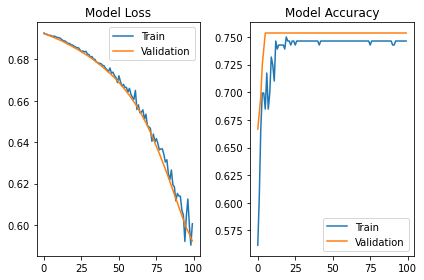

In [16]:
# function for drawing the loss and accuracy curves
def plot_loss_and_accuracy(history):
    
    fig, axs = plt.subplots(1, 2, sharex=True)
    
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].legend(['Train', 'Validation'], loc='upper right')
    
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title('Model Accuracy')
    axs[1].legend(['Train', 'Validation'], loc='lower right')
    
    fig.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)

### Save output to csv
After you're done save your output to the 'classification_results.csv' csv file.<br/>
We assume that the dataframe with your results contain the following columns:
* column 1 (left column): 'test_example_id'  - the same id associated to each of the test stories to be predicted.
* column 2 (right column): 'predicted_category' - the predicted gender value for each of the associated story. 

Assuming your predicted values are in the `df_predicted` dataframe, you should save you're results as following:

In [17]:
# same preprocessing for stories

my_label_predict = model.predict(x_token_test)
my_label_predict_argmax = np.argmax(my_label_predict, axis=-1)

df = np.asarray(df_test['test_example_id']).reshape(-1,1)
array=np.asarray(my_label_predict_argmax).reshape(-1,1)

df_predicted = pd.DataFrame(np.concatenate((df, array), axis=1), columns=['test_example_id', 'predicted_category'])

In [18]:
df_predicted.to_csv('classification_results.csv',index=False) # save csv

In [19]:
from sklearn.metrics import f1_score

y_pred = model.predict(x_f1)
y_pred = np.argmax(y_pred, axis=-1)
y_orig = np.argmax(y_f1, axis=-1)

print('F1 score is', f1_score(y_orig, y_pred, average=None)[1])

F1 score is 0.8125000000000001
